In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import signal
import statsmodels.api as sm
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
import sys
sys.path.append("..")

In [3]:
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示

In [4]:
# 変数群
csv = "../AirPassengers.csv"
index_col = "Month"
col = "#Passengers"
pred_begin = "1960-01-01 00:00"
pred_end = "1963-01-01 00:00"

In [5]:
print(f"{csv.split('.')[-2]}[{col}]")

/AirPassengers[#Passengers]


In [6]:
df = pd.read_csv(csv, index_col=index_col, parse_dates=True, dtype=float)
df.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [7]:
ts = df[col]
ts.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

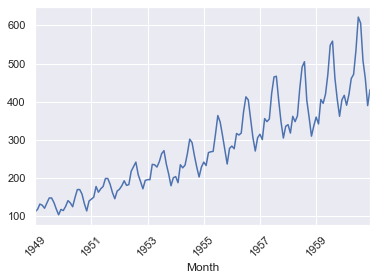

In [8]:
ts.plot(rot=45)

# ARIMAの実装 (s, d, q)

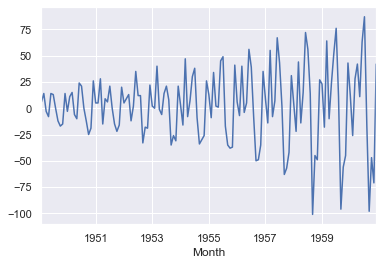

In [9]:
d = 1
ts_diff = ts.diff().dropna() # 差分時系列
ts_diff.plot()

In [10]:
%%time
# 自動ARMA(p, q)パラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(ts_diff, ic='aic', trend='nc')
p, q = res_selection["aic_min_order"]
p, q

CPU times: user 2.57 s, sys: 71.6 ms, total: 2.64 s
Wall time: 1.94 s


(3, 2)

# 周期の推定 (sfq)

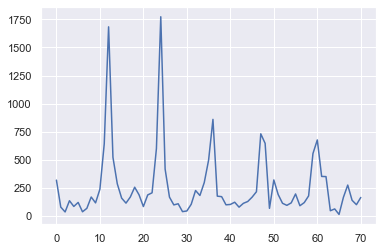

In [11]:
fft = np.fft.fft(ts_diff)
fft_abs = np.abs(fft)
plt.plot(fft_abs[:int(len(fft_abs)/2)])

In [12]:
sfq = signal.argrelmax(fft_abs, order=5)[0][0] # 周期
sfq

12

# パラメータ固定(sp=1, sd=1, sq=1)で高速SARIMAを実装

In [13]:
%%time
# 最速SRIMA
sp = 1
sd = 1
sq = 1
sarimax = sm.tsa.SARIMAX(ts, 
                        order=(p, d, q),
                        seasonal_order=(sp, sd, sq, sfq),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

CPU times: user 2.54 s, sys: 60.2 ms, total: 2.6 s
Wall time: 2.94 s


In [14]:
print(sarimax.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -449.020
Date:                            Sun, 27 Sep 2020   AIC                            914.041
Time:                                    17:26:41   BIC                            936.070
Sample:                                01-01-1949   HQIC                           922.983
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0242      0.796      1.287      0.198      -0.535       2.584
ar.L2          0.0102      0.536   

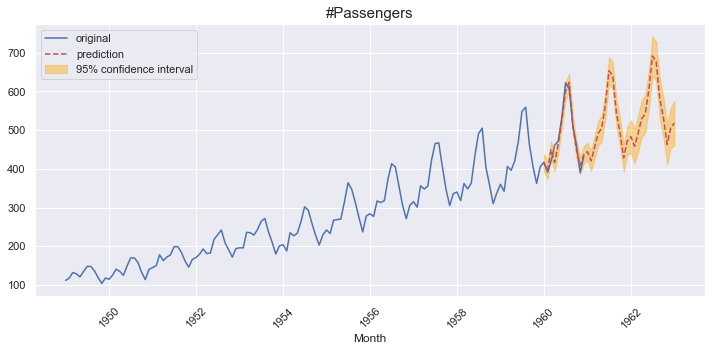

In [15]:
ts_pred = sarimax.get_prediction(pred_begin, pred_end)
pred_conf_int = ts_pred.conf_int(alpha=0.05) # 95%信頼区間

plt.figure(figsize=(12, 5))
plt.title(col, fontsize=15)
plt.plot(ts, label="original")
plt.plot(ts_pred.predicted_mean, "--r", label="prediction")
plt.fill_between(pred_conf_int.index, pred_conf_int.iloc[:, 0], pred_conf_int.iloc[:, 1], 
                 color='orange', alpha=0.4, label="95% confidence interval")
plt.xlabel(index_col)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [16]:
output_df = pd.concat([ts, ts_pred.predicted_mean, pred_conf_int], axis=1)
output_df.columns = [output_df.columns[0], f"prediction {output_df.columns[0]}", 
                     pred_conf_int.columns[0], pred_conf_int.columns[1]]
output_df

,#Passengers,prediction #Passengers,lower #Passengers,upper #Passengers
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,NaN,NaN,NaN
1949-03-01,132.0,NaN,NaN,NaN
1949-04-01,129.0,NaN,NaN,NaN
1949-05-01,121.0,NaN,NaN,NaN
1949-06-01,135.0,NaN,NaN,NaN
1949-07-01,148.0,NaN,NaN,NaN
1949-08-01,148.0,NaN,NaN,NaN
1949-09-01,136.0,NaN,NaN,NaN
1949-10-01,119.0,NaN,NaN,NaN
